In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from dataset import ImageMulti4Channel
from resnet import Resnet4Channel

In [15]:
bs = 64

In [16]:
path = Path('/home/william/data/human-protein-atlas-image-classification/')

In [17]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [18]:
fns = pd.Series([id + '.png' for id in df.Id])
labels = [targ.split(' ') for targ in df.Target]

In [19]:
np.random.seed(42)
trn_ds, val_ds = ImageMulti4Channel.from_folder(path, 'train', fns, labels, classes=[str(i) for i in range(28)])

In [20]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [21]:
test_ds,_ = ImageMulti4Channel.from_folder(
    path, 
    'test', 
    pd.Series(test_ids), 
    [['0'] for _ in range(len(test_ids))],
    valid_pct=0,
    classes=['0'],
)

In [22]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [23]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [25]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), num_workers=8, size=224).normalize(protein_stats)

In [26]:
resnet50 = Resnet4Channel(encoder_depth=50)

In [27]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [28]:
learn = ClassificationLearner(
    data=data,
    model=resnet50,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [29]:
learn.unfreeze()

In [30]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


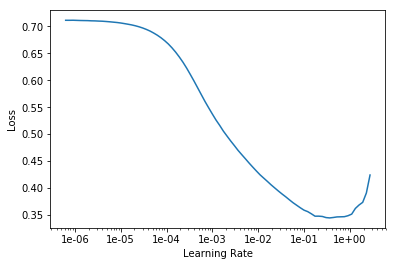

In [31]:
learn.recorder.plot()

In [32]:
lr = 0.01

In [33]:
learn.fit_one_cycle(20, slice(lr))

Total time: 53:05
epoch  train_loss  valid_loss  fbeta   
1      0.130200    0.146852    0.388930  (02:41)
2      0.121962    0.148459    0.442670  (02:40)
3      0.120659    0.125784    0.452106  (02:40)
4      0.118589    0.129387    0.428716  (02:39)
5      0.115391    0.163984    0.447932  (02:39)
6      0.114821    0.138222    0.491987  (02:39)
7      0.109604    0.136291    0.525457  (02:39)
8      0.107522    0.119311    0.522222  (02:39)
9      0.101589    0.131579    0.490353  (02:37)
10     0.100474    0.108896    0.571583  (02:39)
11     0.097399    0.108986    0.582967  (02:38)
12     0.093851    0.106814    0.615101  (02:38)
13     0.089337    0.102818    0.620778  (02:38)
14     0.088372    0.096513    0.616014  (02:38)
15     0.084325    0.089300    0.680281  (02:39)
16     0.080916    0.086166    0.680590  (02:38)
17     0.078836    0.082739    0.689119  (02:38)
18     0.077355    0.080840    0.695626  (02:39)
19     0.076507    0.079993    0.702401  (02:39)
20     0.07

In [38]:
learn.save('resnet50_basic')

In [34]:
preds,_ = learn.get_preds(DatasetType.Test)

/home/william/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/torch/nn/functional.py:1124: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [37]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions.csv', header=True, index=False)